In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
from shapely import Point, wkt
import osmnx as ox
import imageio.v2 as imageio
import glob

# !pip install spatial-kfold
from spatialkfold.blocks import spatial_blocks 
from spatialkfold.clusters import spatial_kfold_clusters 
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut, cross_validate, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor


random_seed = 100

london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
boros = gpd.read_file(os.path.join('data','shapefile','statistical-gis-boundaries-london','ESRI','London_Borough_Excluding_MHW.shp'))
boros.to_crs(epsg=27700, inplace=True)

# Prep data

In [2]:
# load data
df = pd.read_csv('data/cleaned/df_ml_new.csv',low_memory=True)
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:27700')
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    16890 non-null  object  
 1   geometry                   16890 non-null  geometry
 2   population                 16890 non-null  float64 
 3   poi_banking                16890 non-null  float64 
 4   poi_hotels                 16890 non-null  float64 
 5   poi_leisure_active         16890 non-null  float64 
 6   poi_leisure_entertainment  16890 non-null  float64 
 7   poi_leisure_outdoor        16890 non-null  float64 
 8   poi_medical                16890 non-null  float64 
 9   poi_nature                 16890 non-null  float64 
 10  poi_public_facilities      16890 non-null  float64 
 11  poi_religious              16890 non-null  float64 
 12  poi_restaurants            16890 non-null  float64 
 13  poi_shopping           

In [3]:
# Define targets
targets = ['Total', 'Morning', 'Midday', 'Evening', 'Late']
targets_log = ['log_'+t for t in targets]

# Log transform the target variable
for col in targets:
    df['log_'+col] = df[col].apply(lambda x: 0 if x==0 else np.log(x))

In [4]:

# define feature columns
features = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other',
            'diversity_poi','diversity_transp_mode','diversity_transp_opt',
            'cent_bus_degree','cent_bus_closeness','cent_bus_betweenness',
            'cent_rail_degree','cent_rail_closeness','cent_rail_betweenness'
            ]

features_main = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other'
            ]

# lags as features
lags = ['lag_'+t for t in targets] #to pick one depending on the target

# Model Outlier detection

In [5]:
# Load model
with open('data/modeltraining/best_xgb_1407.pkl', 'rb') as file:
    model = pickle.load(file)

In [6]:
# Function to simplify get outliers with residuals outside +/- 1.5*iqr
def get_outliers(df, model, features, target):
    target_sel = 'log_'+target
    features_sel = features + [lags[targets_log.index(target_sel)]] 

    # select the features and target
    X = df[features_sel]  
    y = df[target_sel]

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model.fit(X_scaled, y)

    # Predict the water consumption on test set
    y_pred = model.predict(X_scaled)
    # Calculate the residuals
    residuals = y - y_pred
    
    df['residuals_'+target] = residuals # create new column
    df['is_outlier_'+target] = 0 # create new column

    # Identify buildings with residuals more than +/- 1.5*IQR
    q1 = residuals.quantile(0.25)
    q3 = residuals.quantile(0.75)
    iqr = q3 - q1

    df['is_outlier_'+target] = 0 # create new column
    outliers_upper = df[residuals > q3 + 1.5*iqr] # underpredicting
    outliers_lower = df[residuals < q1 - 1.5*iqr] # overpredicting

    # Mark the outliers
    df.loc[outliers_upper.index, 'is_outlier_'+target] = 1
    df.loc[outliers_lower.index, 'is_outlier_'+target] = 1

    outliers = pd.concat([outliers_upper, outliers_lower])

    return outliers # df with outliers

Timeband: Total
Number of outliers - underpredicting: 249
Number of outliers - overpredicting: 327


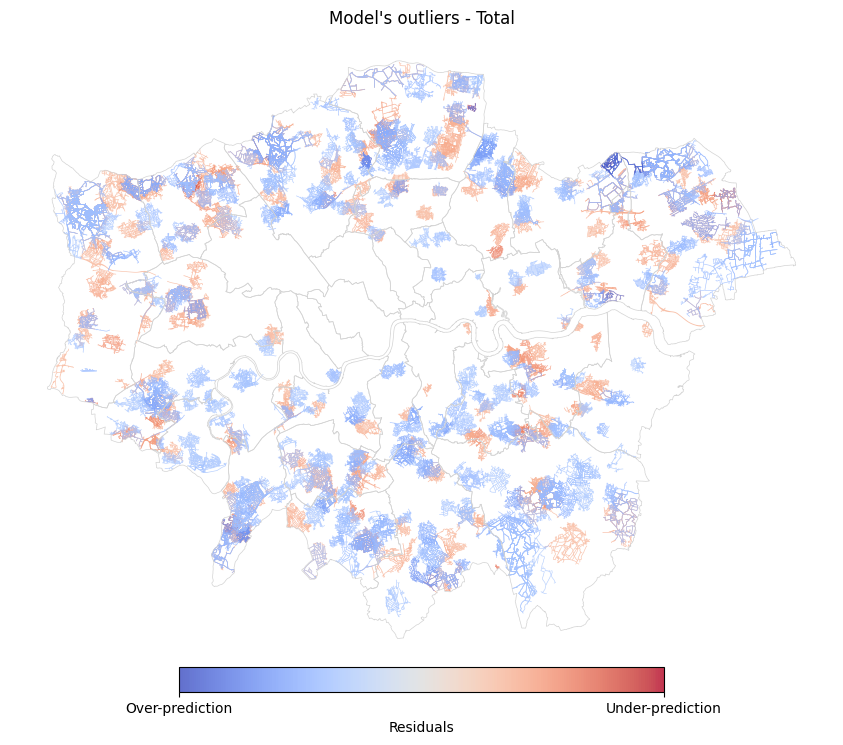

Timeband: Morning
Number of outliers - underpredicting: 249
Number of outliers - overpredicting: 333


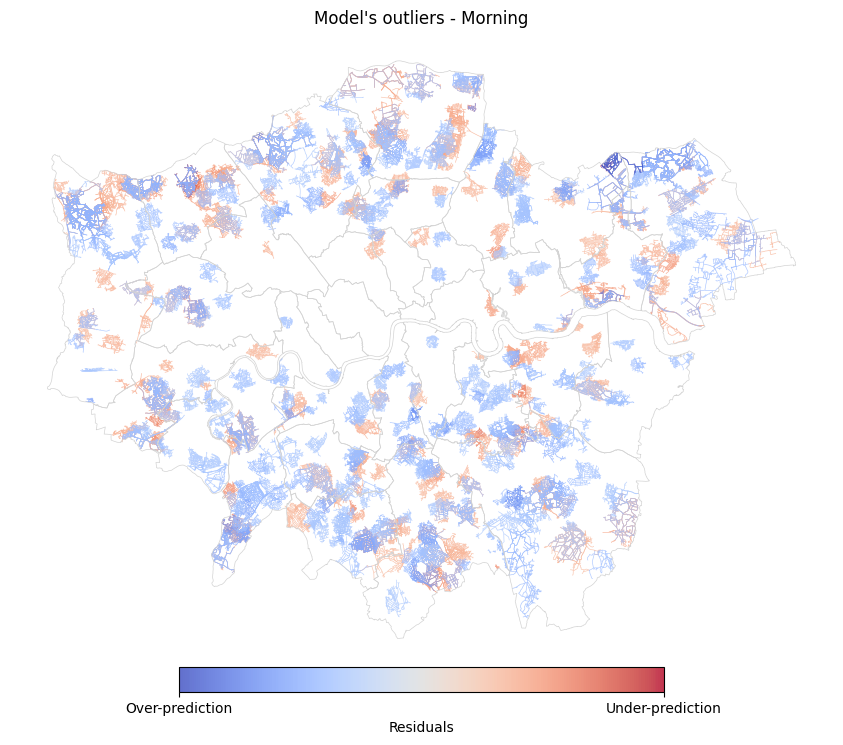

Timeband: Midday
Number of outliers - underpredicting: 266
Number of outliers - overpredicting: 320


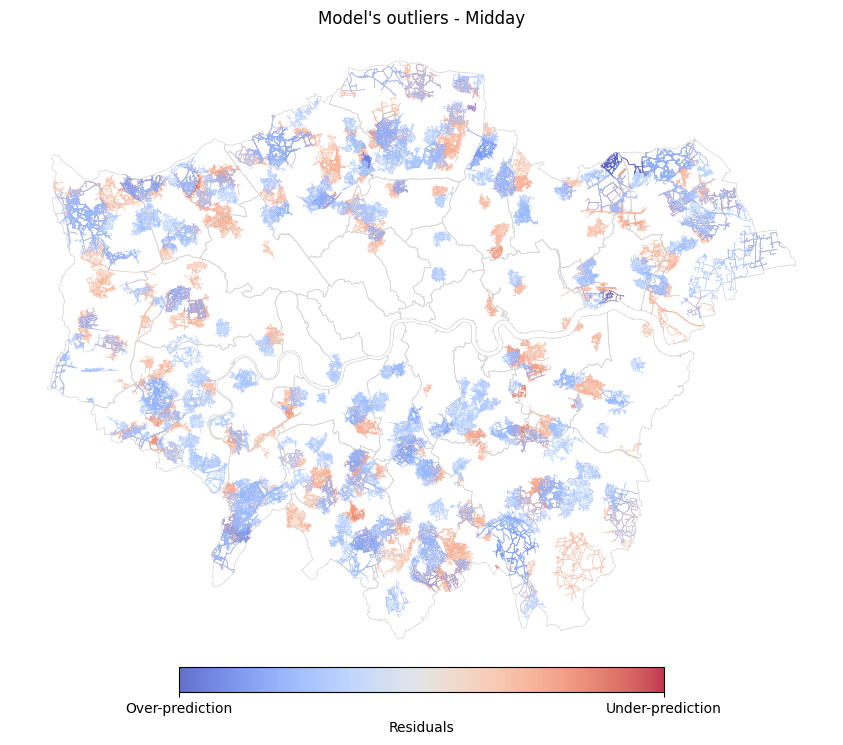

Timeband: Evening
Number of outliers - underpredicting: 292
Number of outliers - overpredicting: 337


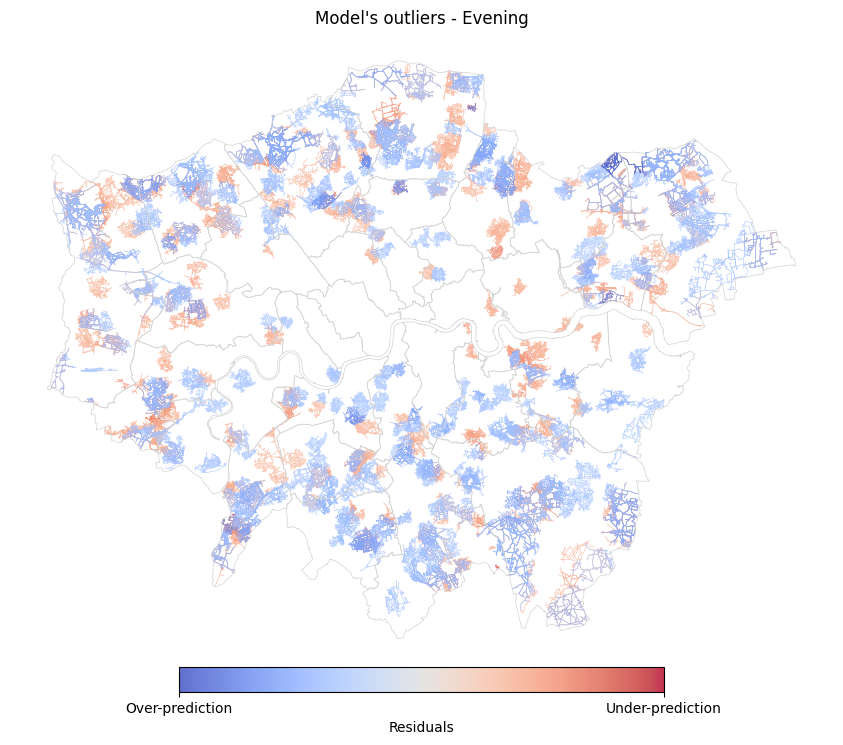

Timeband: Late
Number of outliers - underpredicting: 267
Number of outliers - overpredicting: 327


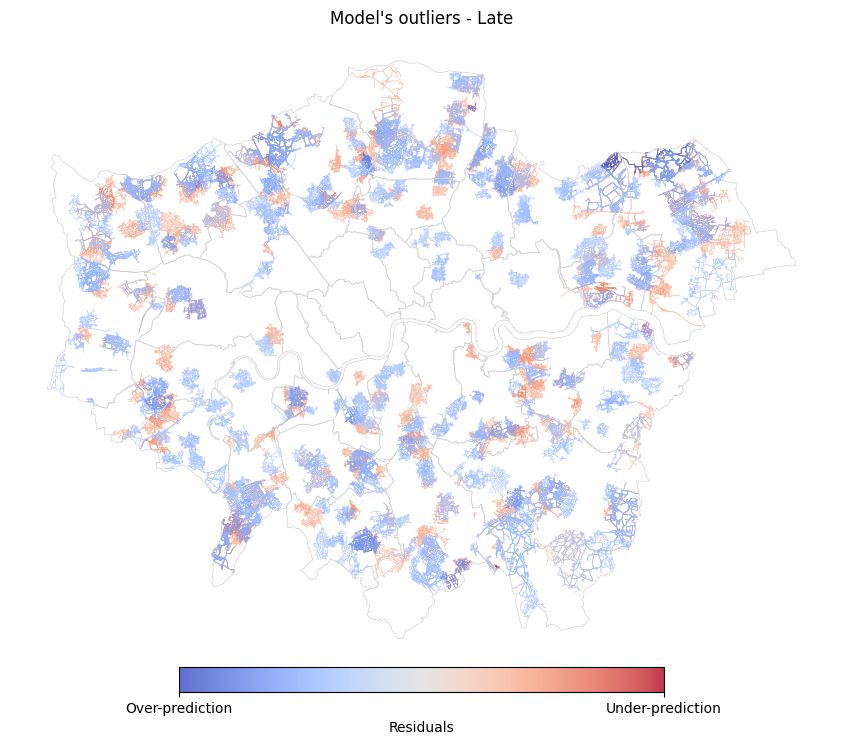

In [7]:
# Get and Plot the outliers for each timeband
for i,target in enumerate(targets):
    
    # Get outliers
    df_outliers = get_outliers(df, model, features, target)
    col_name = 'residuals_'+target

    #Report
    num_outliers_upper = (df_outliers[col_name] > 0).sum()
    num_outliers_lower = (df_outliers[col_name] < 0).sum()

    print(f"Timeband: {target}")
    print(f"Number of outliers - underpredicting: {num_outliers_upper}")
    print(f"Number of outliers - overpredicting: {num_outliers_lower}")

    # Plot
    vmin = -0.07
    vmax = 0.07
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    df_outliers.plot(ax=ax, 
                    column = col_name, 
                    alpha=0.8, legend=False, 
                    cmap='coolwarm',
                    vmin=vmin, vmax=vmax)
                    
    boros.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5)
    
    # Add colorbar
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', ticks=[-0.07, 0.07],shrink=0.5, pad=0)
    cbar.ax.set_xticklabels(['Over-prediction', 'Under-prediction'])  # horizontal colorbar
    cbar.set_label('Residuals')

    plt.title('Model\'s outliers - '+target)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'output/outliers/{i} {target}.png')
    plt.show()

In [8]:
# # create a gif of the outliers for all timebands
# images = []
# for filename in sorted(glob.glob('output/outliers/*.png')):
#     if 'Total' not in filename:
#         images.append(imageio.imread(filename))

# imageio.mimsave('output/outliers/gif/outliers_iqr.gif', images, duration=1000, loop=0)

# Explore outliers

In [9]:
def plot_boro_outlier(boro,target):

    boro_boundary = boros[boros['NAME'] == boro]
    df_boro = df[df.intersects(boro_boundary.unary_union)]

    residual_col = 'residuals_'+target
    outliers_col = 'is_outlier_'+target

    # df_boro_grouped = df_boro.groupby(outliers_col)[features_main].agg(['mean','median'])
    # print(df_boro_grouped)

    # plot outliers and non-outliers in Enfield, color by residuals_target
    fig, ax = plt.subplots(1, 2, figsize=(8, 15), sharex=True, sharey=True)

    vmin = -0.07
    vmax = 0.07

    df_boro[df_boro[outliers_col] == 0].plot(ax=ax[0], 
                                                    column = residual_col, 
                                                    alpha=0.8, vmin=vmin, vmax=vmax,
                                                    cmap='coolwarm')
    ax[0].set_title(f'Non-Outliers - {boro.title()}')

    df_boro[df_boro[outliers_col] == 1].plot(ax=ax[1],
                                                    column = residual_col, 
                                                    alpha=0.8, vmin=vmin, vmax=vmax,   
                                                    cmap='coolwarm')    
    ax[1].set_title(f'Outliers - {boro.title()}')

    # shared legend colorbar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', label='Residuals',shrink=0.5, pad=0,ticks=[-0.07, 0.07])
    cbar.ax.set_xticklabels(['Over-prediction', 'Under-prediction'])  # horizontal

    for a in ax:
        a.axis('off')
        boro_boundary.boundary.plot(ax=a, color='black', linewidth=0.5)
        
    plt.show()

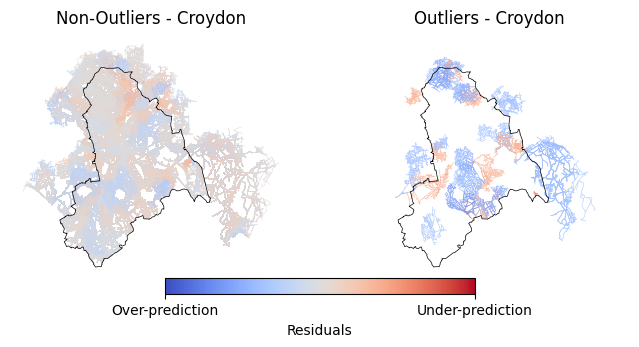

In [10]:
plot_boro_outlier('Croydon','Total')

In [18]:
df_boro.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1370 entries, 5 to 16877
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    1370 non-null   object  
 1   geometry                   1370 non-null   geometry
 2   population                 1370 non-null   float64 
 3   poi_banking                1370 non-null   float64 
 4   poi_hotels                 1370 non-null   float64 
 5   poi_leisure_active         1370 non-null   float64 
 6   poi_leisure_entertainment  1370 non-null   float64 
 7   poi_leisure_outdoor        1370 non-null   float64 
 8   poi_medical                1370 non-null   float64 
 9   poi_nature                 1370 non-null   float64 
 10  poi_public_facilities      1370 non-null   float64 
 11  poi_religious              1370 non-null   float64 
 12  poi_restaurants            1370 non-null   float64 
 13  poi_shopping               13

C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


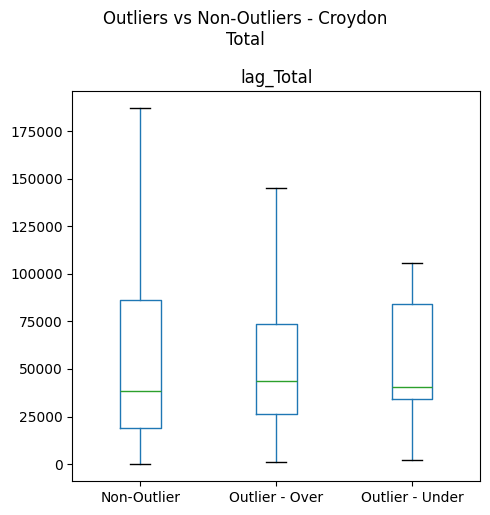

In [22]:
chosen_boro = 'Croydon'

# mean testing to see if the outliers and non-outliers are significantly different
df_boro = df[df.intersects(boros[boros['NAME'] == chosen_boro].unary_union)]

# over_under column based on residuals of Total
df_boro['over_under'] = np.where(df_boro['residuals_Total'] > 0, 'under', 'over')
df_boro['is_outlier_Total_'] = df_boro['is_outlier_Total'].replace({0: 'Non-Outlier', 1: 'Outlier'})
df_boro['is_outlier_Total_'] = np.where((df_boro['is_outlier_Total_'] == 'Outlier') & (df_boro['over_under'] == 'under'), 'Outlier - Under', df_boro['is_outlier_Total_'])
df_boro['is_outlier_Total_'] = np.where((df_boro['is_outlier_Total_'] == 'Outlier') & (df_boro['over_under'] == 'over'), 'Outlier - Over', df_boro['is_outlier_Total_'])

# boxplot for df_boro_grouped
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

df_boro.boxplot(column='lag_Total', by='is_outlier_Total_', ax=ax, showfliers=False)
ax.set_title('lag_Total')
ax.set_xlabel('')
ax.grid(False)

plt.tight_layout()
plt.suptitle('Outliers vs Non-Outliers - '+chosen_boro.title()+'\nTotal', y=1.02)
plt.show()


# # boxplot for df_boro_grouped
# fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# for i,feature in enumerate(features):
#     ax = axes.flatten()[i]
#     df_boro.boxplot(column=feature, by='is_outlier_Total_', ax=ax, showfliers=False)
#     # df_boro_grouped[feature].plot(kind='bar', ax=ax, legend=False)
#     ax.set_title(feature)
#     ax.set_xlabel('')
#     ax.grid(False)
#     if i >= 20:
#         ax.set_xticklabels(['Non-\nOutliers', 'Outliers\nOverpred.', 'Outliers\nUnderpred.'])
#     else:
#         ax.set_xticklabels([])

# plt.tight_layout()
# plt.suptitle('Outliers vs Non-Outliers - '+chosen_boro.title()+'\nTotal', y=1.02)
# plt.show()

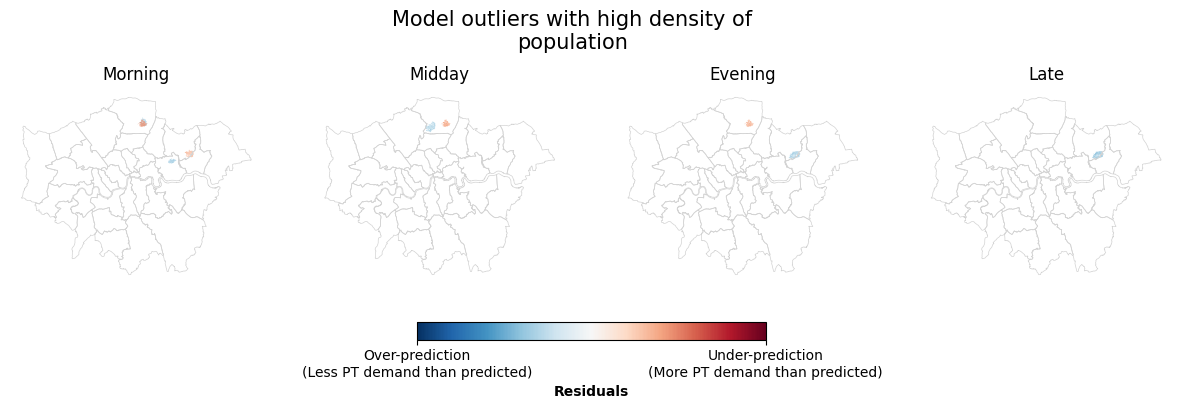

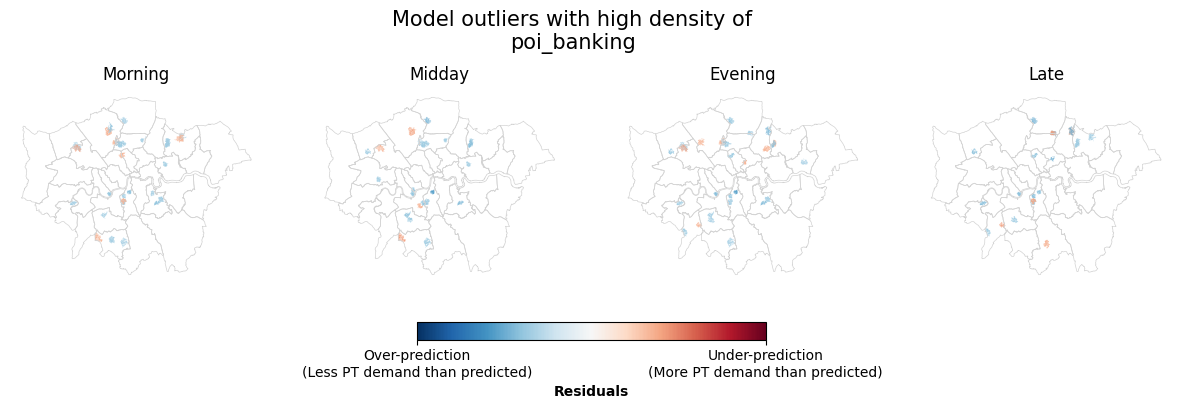

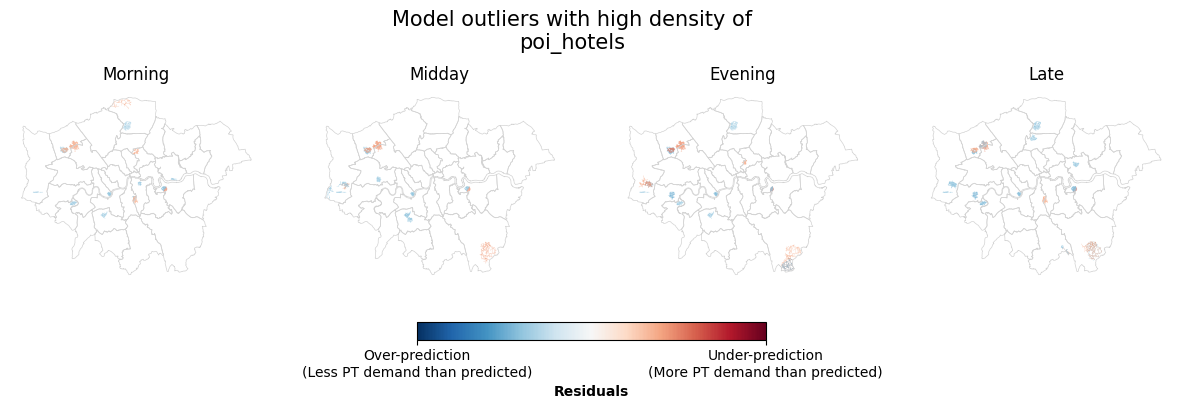

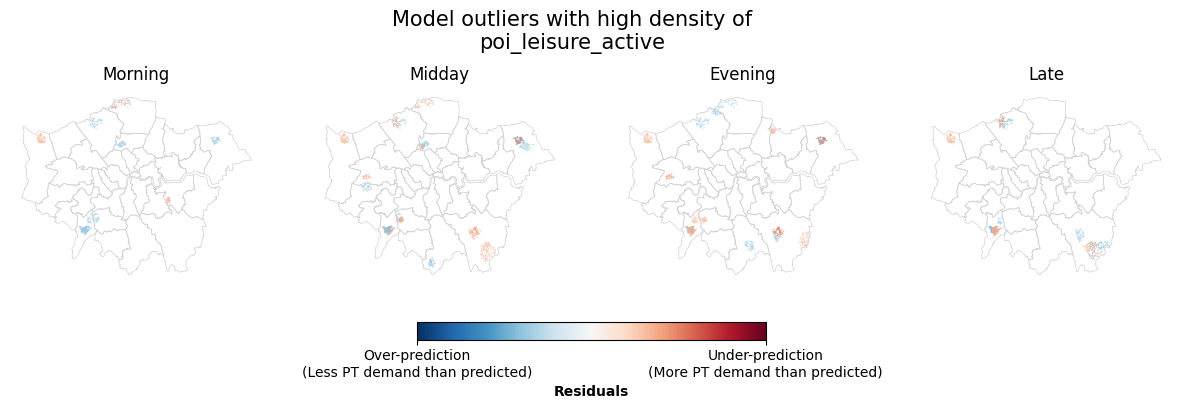

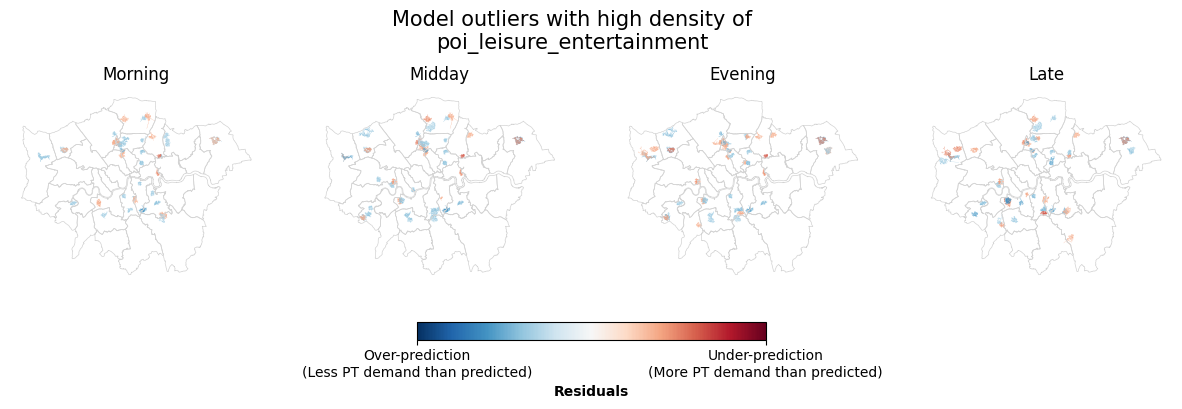

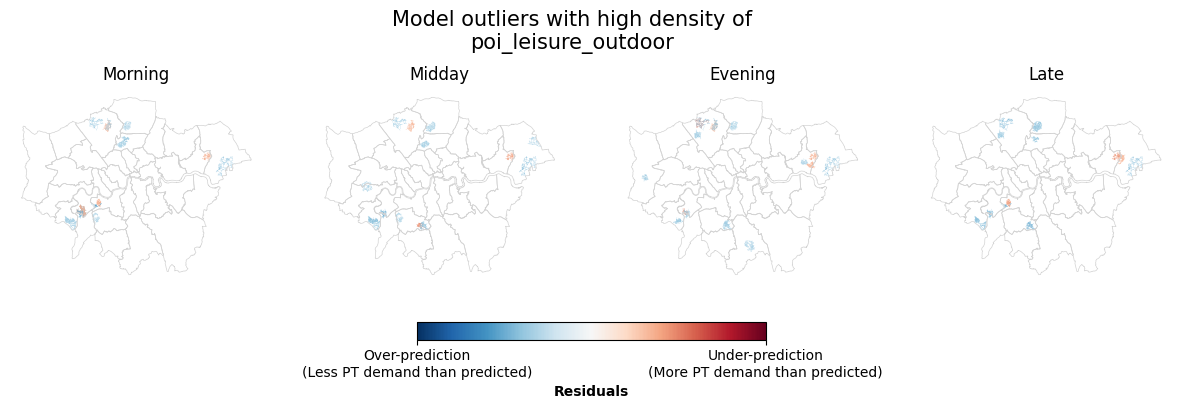

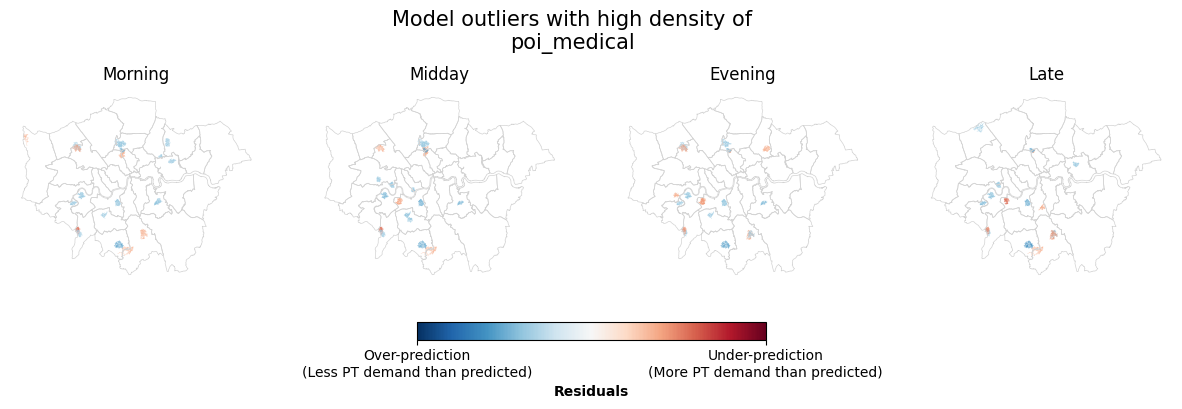

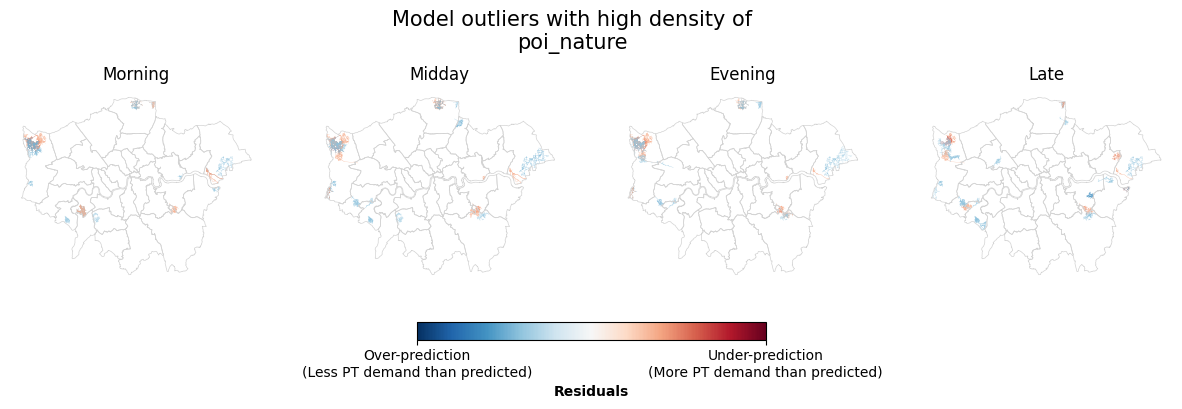

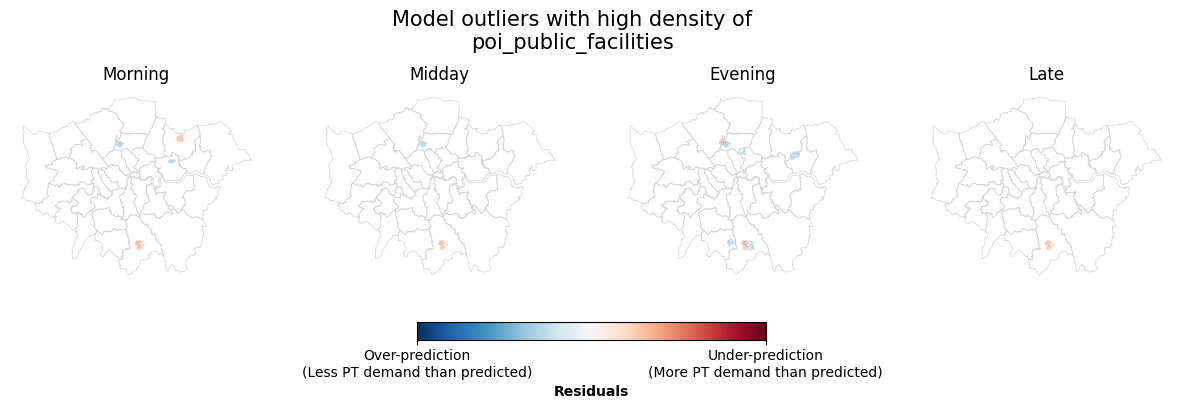

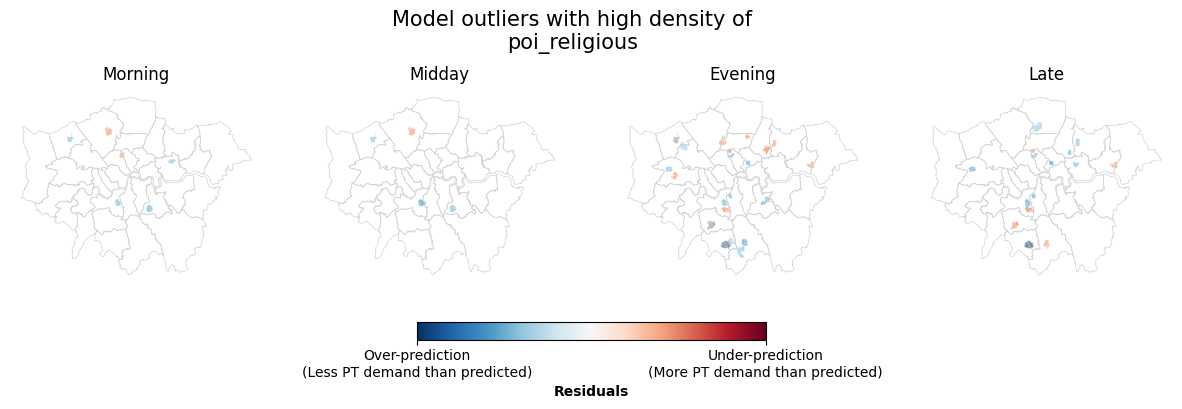

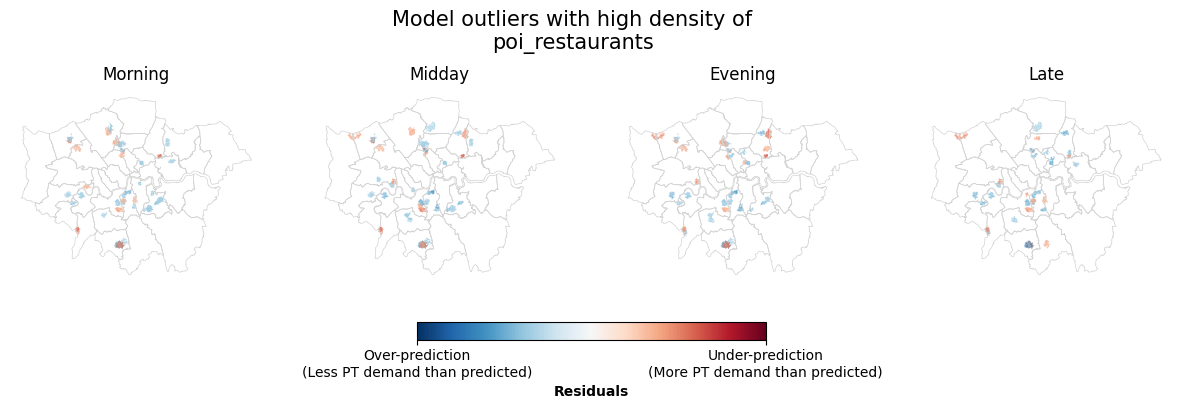

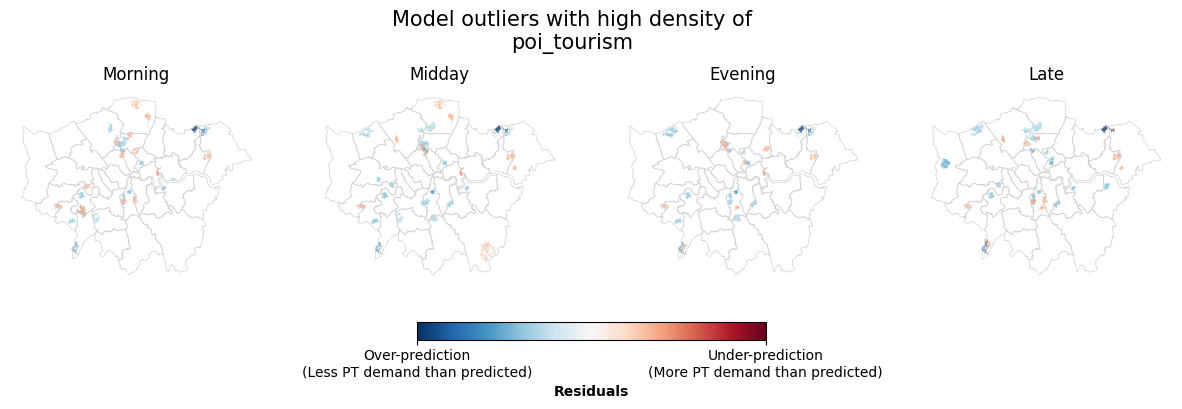

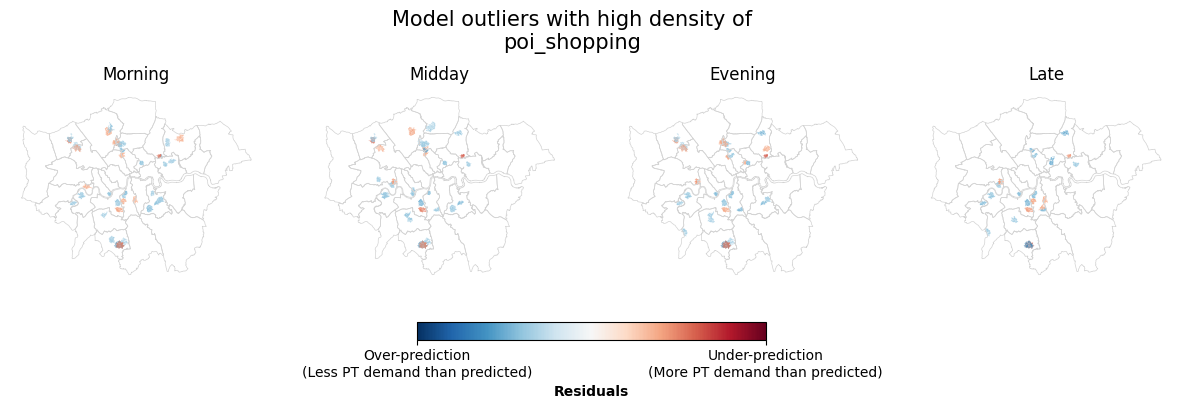

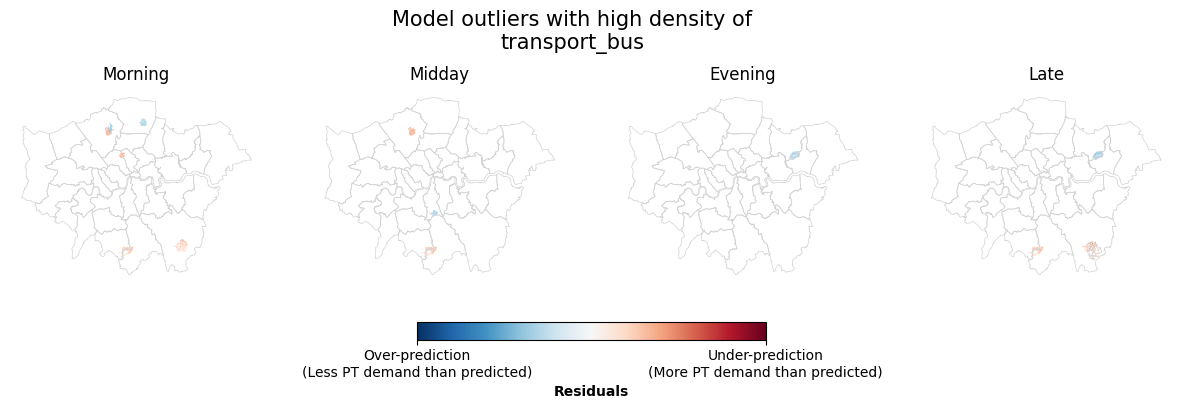

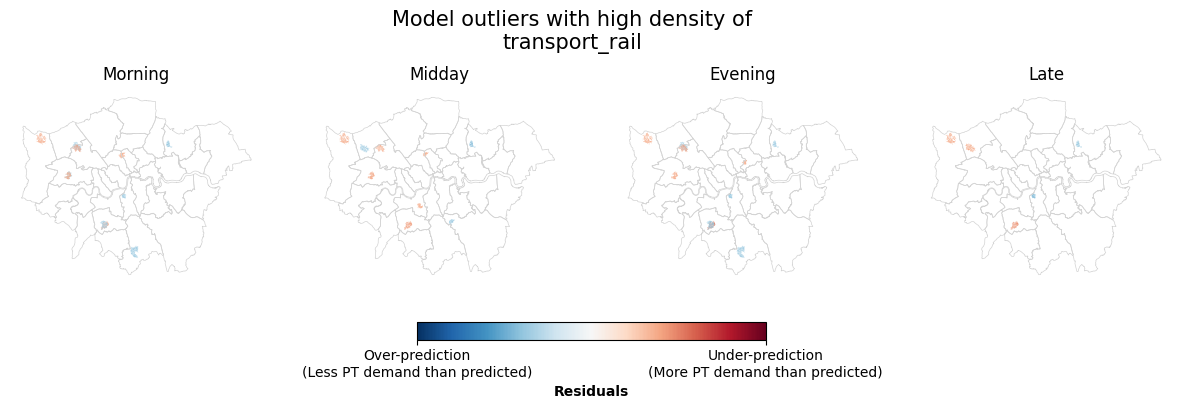

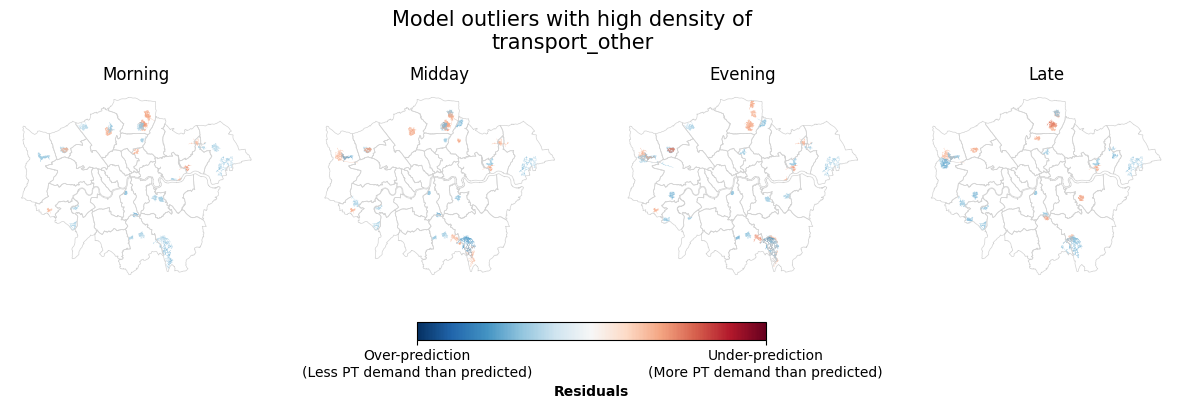

In [99]:
# extract the outliers for each feature and timeband
for feature in features_main:  
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax= ax.flatten()
    for i,target in enumerate(targets[1:]):   

        # Get outliers           
        df_outlier_toPlot = df[df[f'is_outlier_{target}']==1]
        
        q1 = df_outlier_toPlot[feature].quantile(0.25)
        q3 = df_outlier_toPlot[feature].quantile(0.75)

        iqr = q3 - q1
        lower_bound = q1 - 1.5*iqr
        upper_bound = q3 + 1.5*iqr
        
        df_plot = df_outlier_toPlot[(df_outlier_toPlot[feature] > upper_bound)]
        
        col_name = 'residuals_'+target

        # Plot
        vmin = -0.07
        vmax = 0.07
        df_plot.plot(ax=ax[i], 
                    column = col_name, 
                    alpha=1, legend=False, 
                    cmap='RdBu_r',
                    vmin=vmin, vmax=vmax)
        
        ax[i].set_title(f'{target}')
        ax[i].axis('off')
                    
        boros.boundary.plot(ax=ax[i], color='lightgrey', linewidth=0.5)
    
    # Add colorbar
    cbar = fig.colorbar(ax[0].collections[0], ax=ax, orientation='horizontal', ticks=[-0.07, 0.07],shrink=0.3, pad=0.1)
    cbar.ax.set_xticklabels(['Over-prediction\n(Less PT demand than predicted)', 'Under-prediction\n(More PT demand than predicted)'])  # horizontal colorbar
    cbar.set_label('Residuals', loc='center', weight='bold')

    plt.axis('off')
    plt.suptitle(f'Model outliers with high density of\n{feature}',y=0.85, fontsize=15)
    plt.savefig(f'output/outliers/{feature}_alltimebands.jpg')
    plt.show()
    

    ## UNDERPREDICTION: more inflow than predicted based on profile
    ## OVERPREDICTION: less inflow than predicted based on profile

In [68]:
df.to_csv('data/cleaned/df_ml_new_resid.csv', index=False)

# ---- Testing Ground

In [340]:
# define feature columns
features = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other',
            'diversity_poi','diversity_transp_mode','diversity_transp_opt',
            'cent_bus_degree','cent_bus_closeness','cent_bus_betweenness',
            'cent_rail_degree','cent_rail_closeness','cent_rail_betweenness'
            ]

features_xy = features + ['x_coords','y_coords']


# lags as features
lags = ['lag_'+t for t in targets] #to pick one depending on the target

## Train + SHAP for each boro

In [375]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

In [380]:
def train_model_boro(boro, model):
    # dictionary with 4 columns for Timeband, MAE, MSE, R2

    results_xgb = pd.DataFrame()

    df_boro = df[df.intersects(boros[boros['NAME'] == boro].unary_union)]

    # iterate for each tuned model above
    for target in targets_log: # use log_ for target
        target_sel = target
        features_sel = features + [lags[targets_log.index(target_sel)]]

        # select the features and target
        X = df_boro[features_sel]  
        y = df_boro[target_sel]

        # cv setup
        df_point = df_boro.copy()
        df_point['geometry'] = [Point(x,y) for x,y in zip(df_point['x_coords'],df_point['y_coords'])]
        df_point = gpd.GeoDataFrame(df_point, geometry='geometry', crs='EPSG:27700')

        # spatial kfold
        df_clusters = spatial_kfold_clusters (gdf=df_point, name = 'id_code', nfolds = 5, algorithm='kmeans',
                                                random_state = random_seed, verbose = False) 

        groups = df_clusters["folds"] # Cross-validation grouping setup
        group_cvs =  LeaveOneGroupOut() # for spatial cross-validation when training the data

        # list to store the scores for each fold so that we can calculate the mean later
        mae_scores = []
        mse_scores = []
        r2_scores = []

        # iterate for each log_ target
        for train_index, test_index in group_cvs.split(X, y, groups=groups):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Standardize the data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Fit the model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Calculate the scores, add to the list
            mae_scores.append(mean_absolute_error(y_test, y_pred))
            mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
            r2_scores.append(r2_score(y_test, y_pred))

        # Calculate the mean scores
        mean_mae = np.mean(mae_scores)
        mean_mse = np.mean(mse_scores)
        mean_r2 = np.mean(r2_scores)

        # add the mean scores to the dataframe
        ddf = pd.DataFrame({'Timeband': [target], 'MAE': [mean_mae], 'MSE': [mean_mse], 'R2': [mean_r2]})
        results_xgb = pd.concat([results_xgb, ddf], ignore_index=True,axis=0)
        print(f"\n{target} done")

    return results_xgb

In [381]:
#linearregression
chosen_model = LinearRegression()

results_camden = train_model_boro('Camden',model=chosen_model)
results_camden

Timeband       MAE       MSE        R2
0    log_Total  0.737650  1.278856  0.307535
1  log_Morning  0.613671  0.764996  0.479593
2   log_Midday  0.735110  1.282427  0.306205
3  log_Evening  0.812089  1.430529  0.191885
4     log_Late  0.838801  1.601632 -0.039684

In [383]:
#mlp
chosen_model = MLPRegressor((100,100),early_stopping=True,max_iter=1000,random_state=random_seed)

results_camden = train_model_boro('Camden',model=chosen_model)
results_camden

Timeband       MAE        MSE        R2
0    log_Total  2.002456  21.700958 -8.178220
1  log_Morning  1.582360  12.523867 -5.471310
2   log_Midday  1.940924  20.381261 -7.549524
3  log_Evening  1.757917  15.427937 -6.801278
4     log_Late  1.519864  11.144893 -6.948874

In [368]:
#xgboost
chosen_model = XGBRegressor(n_estimators=1000, max_depth=8, random_state=random_seed)

results_camden = train_model_boro('Camden',model=chosen_model)
results_camden

Timeband       MAE       MSE        R2
0    log_Total  0.564420  0.714436  0.574538
1  log_Morning  0.520749  0.541604  0.611822
2   log_Midday  0.551570  0.707714  0.572637
3  log_Evening  0.613152  0.710749  0.556017
4     log_Late  0.567958  0.597694  0.616587

In [357]:
# Func obtain SHAP Explainer object for a single boro
def shap_boro(boro, model, features, target):
    boro_boundary = boros[boros['NAME'] == boro]
    df_boro = df[df.intersects(boro_boundary.unary_union)]

    target_sel = 'log_'+target
    features_sel = features + [lags[targets_log.index(target_sel)]]

    # select the features and target
    X = df_boro[features_sel]  
    y = df_boro[target_sel]

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model.fit(X_scaled, y)

    # Calculate SHAP values
    explainer = shap.Explainer(model, shap.sample(X_scaled, 500, random_state=random_seed))
    X_scaled = pd.DataFrame(X_scaled, columns=features_sel)
    shap_values = explainer(X_scaled)

    return shap_values


 99%|===================| 479/482 [02:11<00:00]        

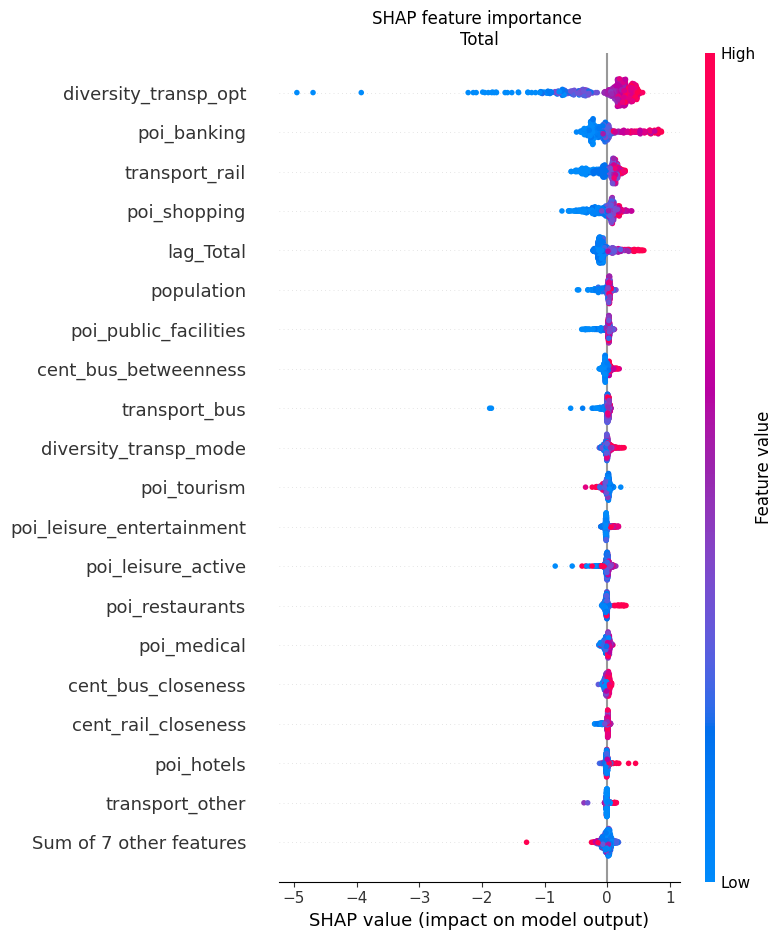

100%|===================| 480/482 [02:03<00:00]        

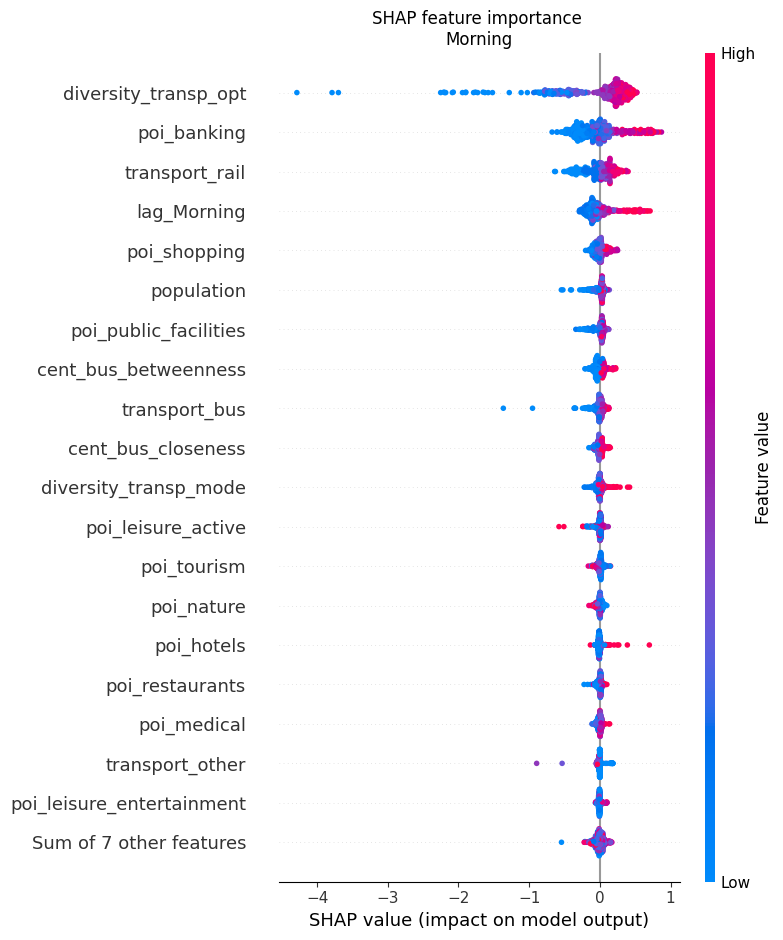

 99%|===================| 479/482 [01:56<00:00]        

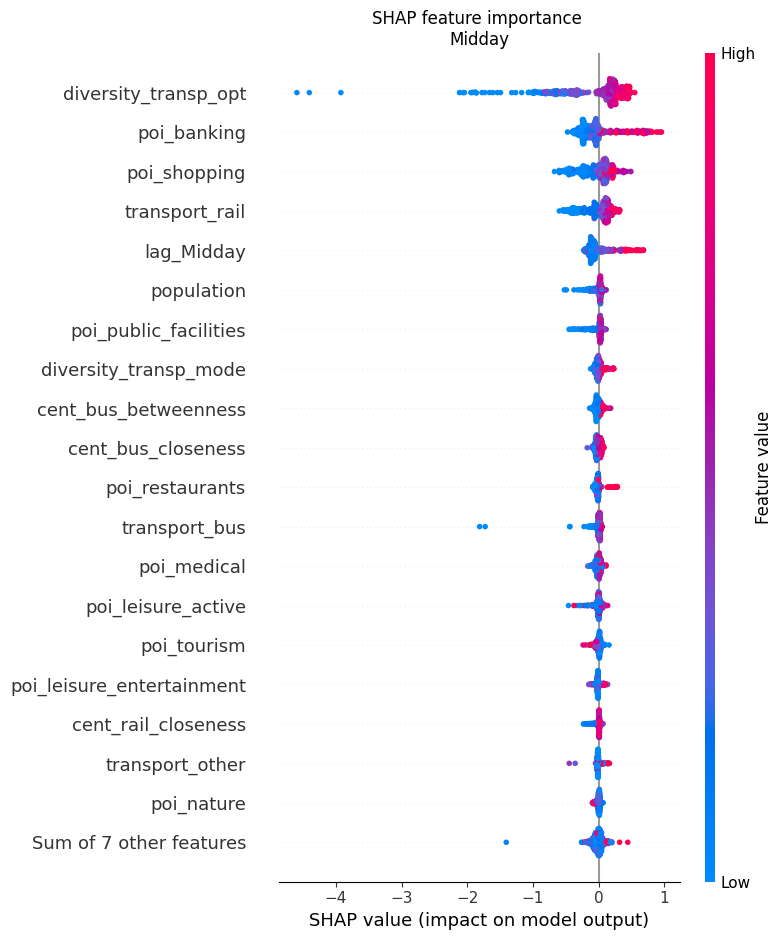

 99%|===================| 479/482 [02:04<00:00]        

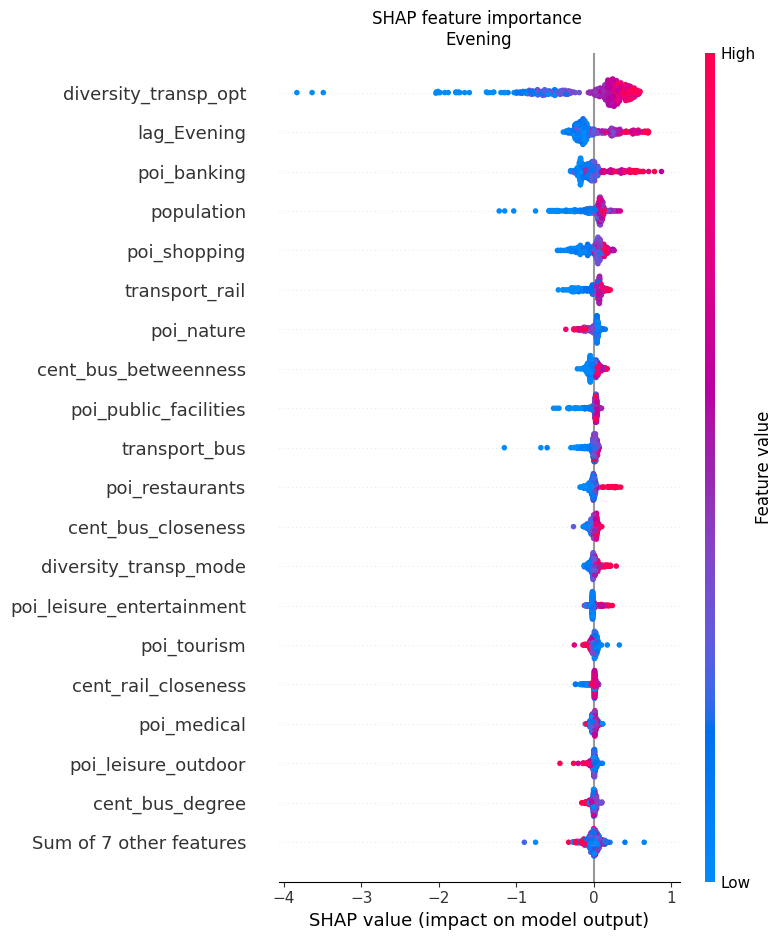

 99%|===================| 479/482 [01:41<00:00]        

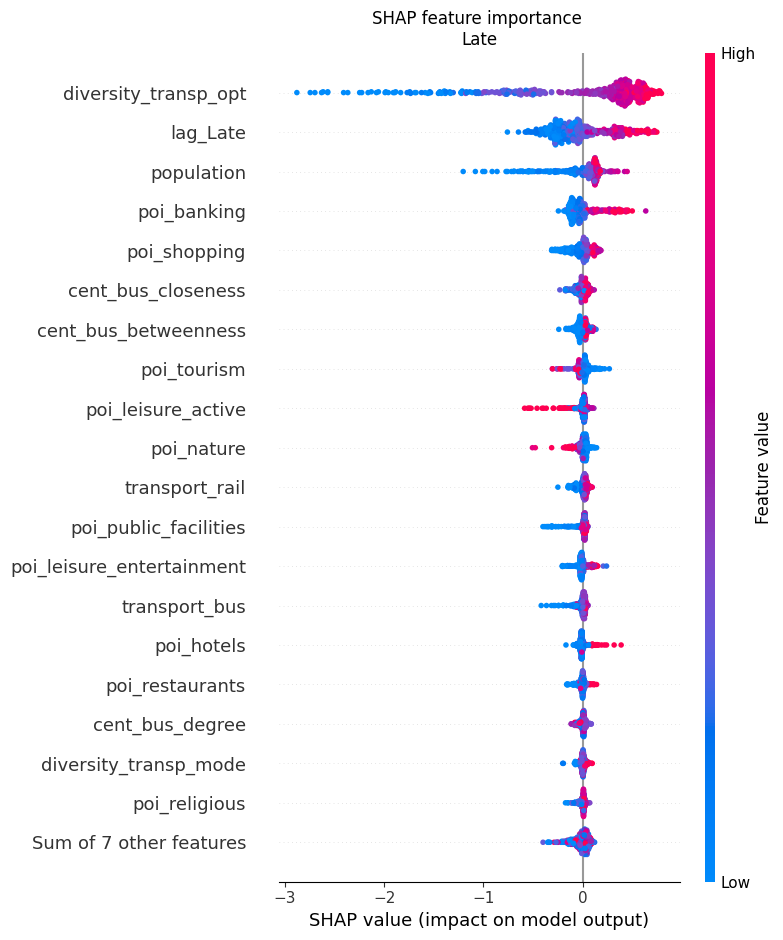

In [361]:
for target in targets:
    shap_boro_test = shap_boro('Camden', model, features, target)
    shap.plots.beeswarm(shap_boro_test, max_display=20,show=False)
    plt.title('SHAP feature importance - Camden\n'+target)
    plt.tight_layout()
    plt.show()

## Train original model Without lags

In [ ]:
# Set up spatial cross-validation folds

df_point = df.copy()
df_point['geometry'] = [Point(x,y) for x,y in zip(df_point['x_coords'],df_point['y_coords'])]
df_point = gpd.GeoDataFrame(df_point, geometry='geometry', crs='EPSG:27700')

# spatial kfold
df_clusters = spatial_kfold_clusters (gdf=df_point, name = 'id_code', nfolds = 5, algorithm='kmeans',
                                        random_state = random_seed, verbose = False) 

groups = df_clusters["folds"] # Cross-validation grouping setup
group_cvs =  LeaveOneGroupOut() # for spatial cross-validation when training the data
# group_kfold = GroupKFold(n_splits=10) # for spatial cross-validation when testing the data
groups.unique()

In [385]:
##without tuning, use the best models from the previous notebook

# Load tuned model log_Total from last notebook to initialize
with open('data/modeltraining/best_xgb_1407.pkl', 'rb') as file:
    model = pickle.load(file)
# load base models dictionary

# dictionary with 4 columns for Timeband, MAE, MSE, R2
results_xgb = pd.DataFrame()

# iterate for each tuned model above
for target in targets_log: # use log_ for target
    target_sel = target
    features_sel = features

    # select the features and target
    X = df[features_sel]  
    y = df[target_sel]

    # list to store the scores for each fold so that we can calculate the mean later
    mae_scores = []
    mse_scores = []
    r2_scores = []

    # iterate for each log_ target
    for train_index, test_index in group_cvs.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate the scores, add to the list
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
        r2_scores.append(r2_score(y_test, y_pred))

    # Calculate the mean scores
    mean_mae = np.mean(mae_scores)
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    print(f"\n{target}:")
    print(f"Mean MAE: {mean_mae}")
    print(f"Mean MSE: {mean_mse}")
    print(f"Mean R^2: {mean_r2}")

    # add the mean scores to the dataframe
    ddf = pd.DataFrame({'Timeband': [target], 'MAE': [mean_mae], 'MSE': [mean_mse], 'R2': [mean_r2]})
    results_xgb = pd.concat([results_xgb, ddf], ignore_index=True,axis=0)

results_xgb


log_Total:
Mean MAE: 0.630917953788334
Mean MSE: 0.826368198718274
Mean R^2: 0.7873813536119658

log_Morning:
Mean MAE: 0.6495169997121272
Mean MSE: 0.8063751427264145
Mean R^2: 0.7496107207821775

log_Midday:
Mean MAE: 0.6051973835501815
Mean MSE: 0.7435134530521988
Mean R^2: 0.7982937628822685

log_Evening:
Mean MAE: 0.6814245076839289
Mean MSE: 0.878628071721252
Mean R^2: 0.76853063496565

log_Late:
Mean MAE: 0.7362392450870507
Mean MSE: 0.9051667960517997
Mean R^2: 0.7470962570813935


Timeband       MAE       MSE        R2
0    log_Total  0.630918  0.826368  0.787381
1  log_Morning  0.649517  0.806375  0.749611
2   log_Midday  0.605197  0.743513  0.798294
3  log_Evening  0.681425  0.878628  0.768531
4     log_Late  0.736239  0.905167  0.747096

In [346]:
%%time
# For each of the models, obtain SHAP Explainer object for test data
shap_list_ = {} # test data

for target in targets_log:  
    
    # select the features and target
    X = df[features]
    y = df[target]
    
    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # fit the model
    model.fit(X, y)

    # Create a SHAP explainer object
    background = shap.sample(X, 1000, random_state=random_seed)
    explainer = shap.Explainer(model, background)

    # Explain the X_test data
    print(f"Explaining {target}...for 1000 rows")
    # Explain a subset of the dataset
    X_explain = pd.DataFrame(X, columns=features)
    X_explain = X_explain.sample(1000, random_state=random_seed,axis=0)

    shap_values1 = explainer(X_explain)
    shap_list_[target]= shap_values1 # add to the dictionary - test data
    

# # export shap_list
# with open('data/modeltraining/shap_list_test.pkl', 'wb') as file:
#     pickle.dump(shap_list_, file)

Explaining log_Morning...for 1000 rows


100%|===================| 999/1000 [22:31<00:01]        

Explaining log_Midday...for 1000 rows


100%|===================| 999/1000 [24:41<00:01]        

Explaining log_Evening...for 1000 rows


100%|===================| 999/1000 [25:01<00:01]        

Explaining log_Late...for 1000 rows


100%|===================| 999/1000 [25:49<00:01]        

CPU times: total: 31min 42s
Wall time: 1h 45min 5s


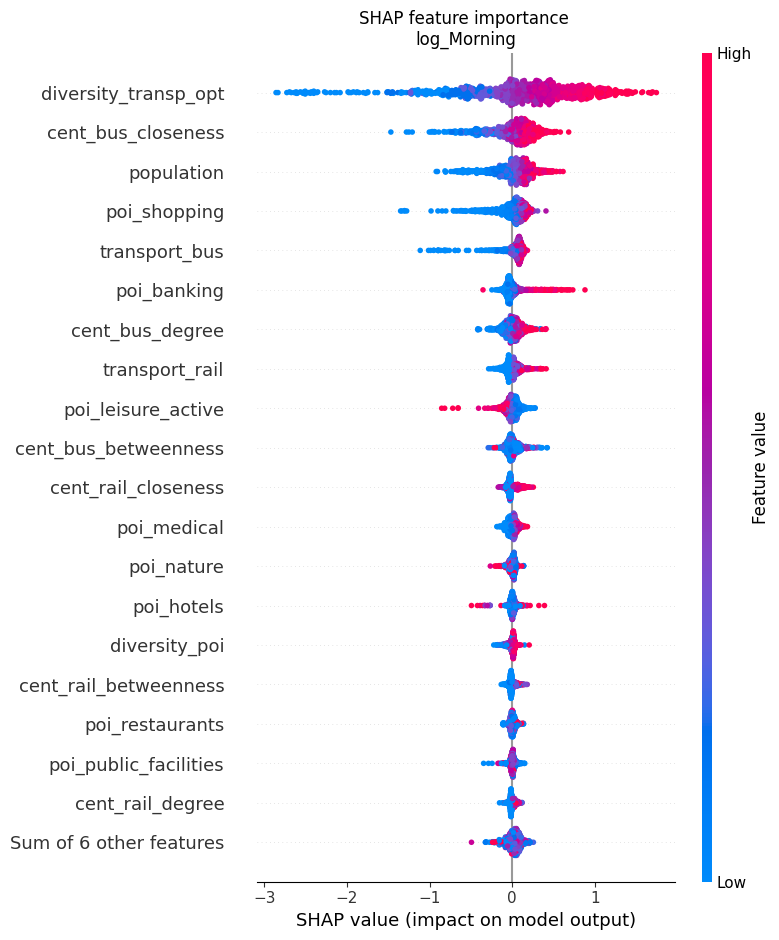

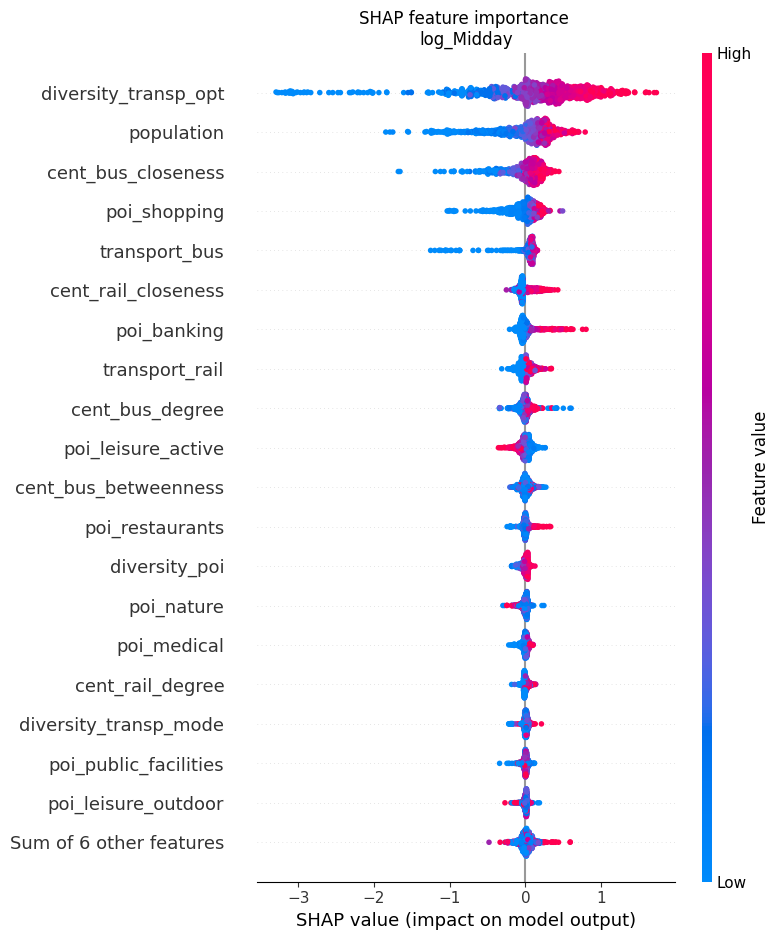

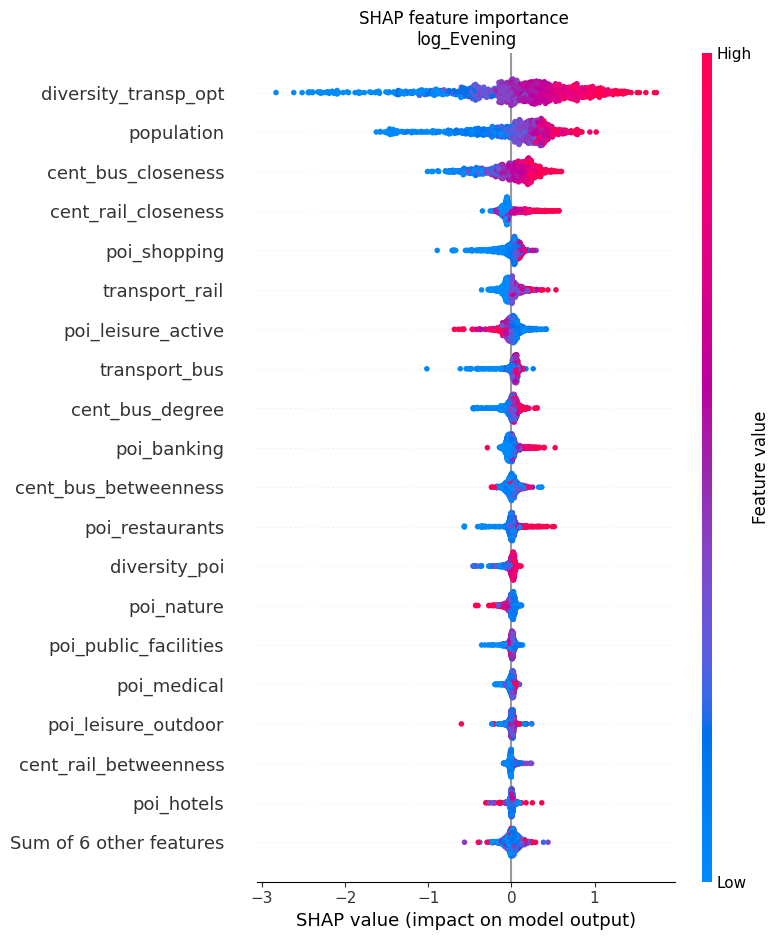

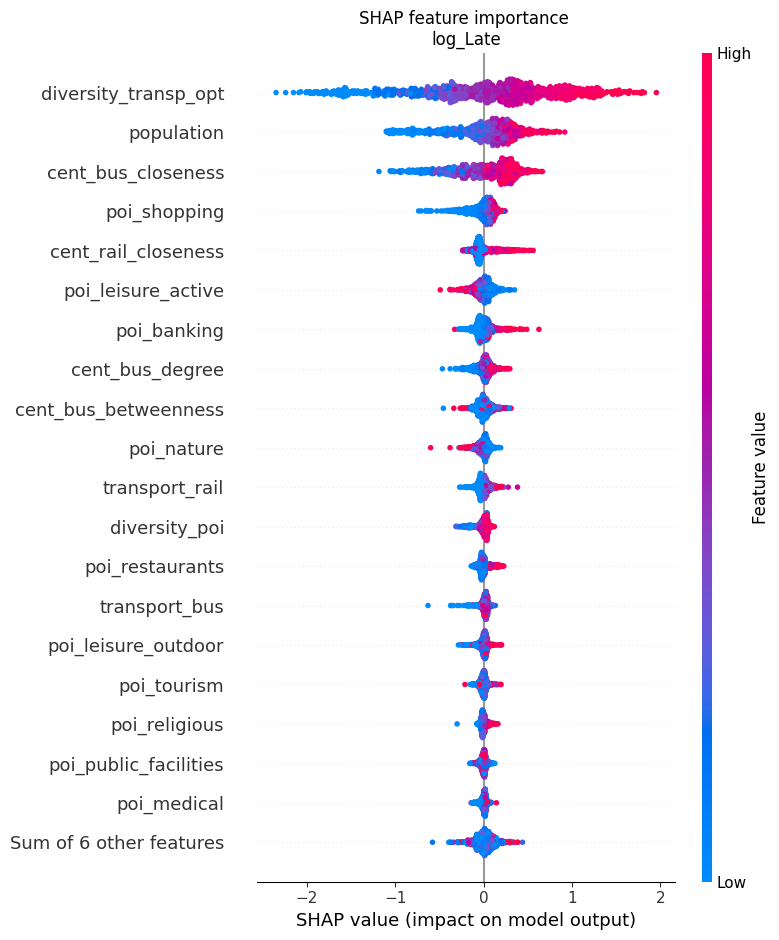

In [347]:
for target in targets_log[1:]:
    shap_values = shap_list_[target]
    
    shap.plots.beeswarm(shap_values, max_display=20,show=False)

    plt.title('SHAP feature importance \n'+target)
    plt.tight_layout()
    # plt.savefig(f'output/shap/new_{target}.png')
    plt.show()

26it [00:41,  2.17s/it]                        


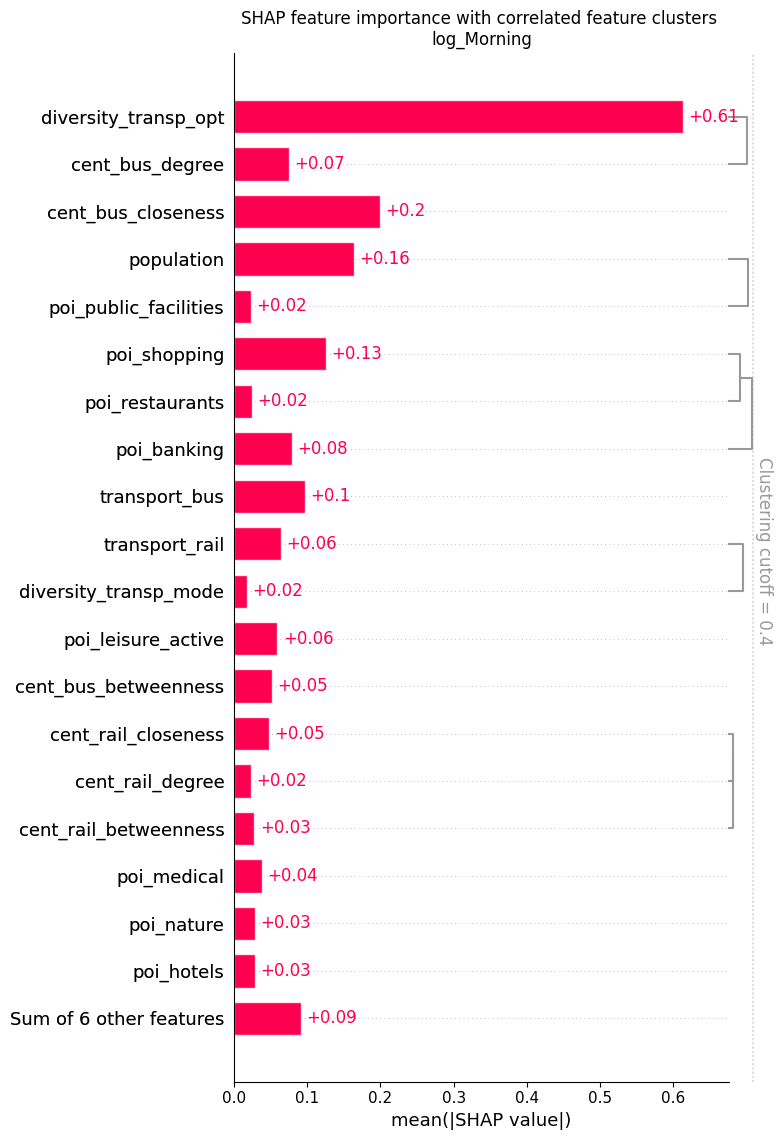

26it [00:47,  2.37s/it]                        


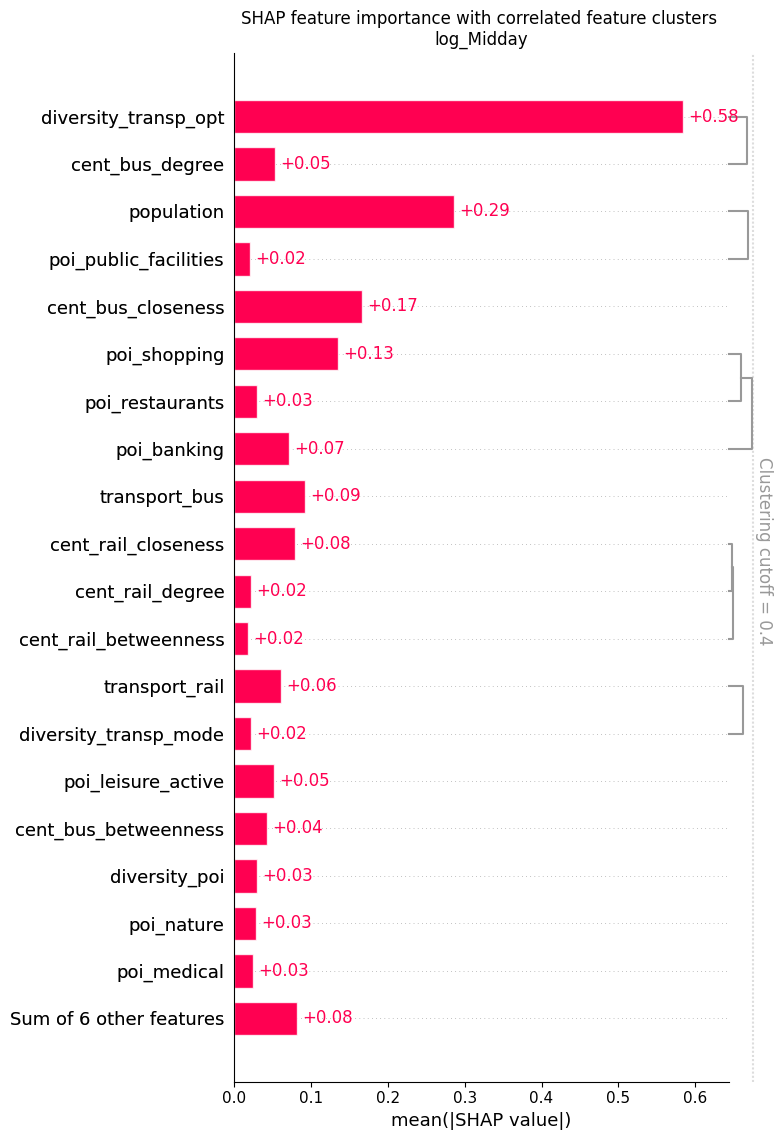

26it [00:43,  2.19s/it]                        


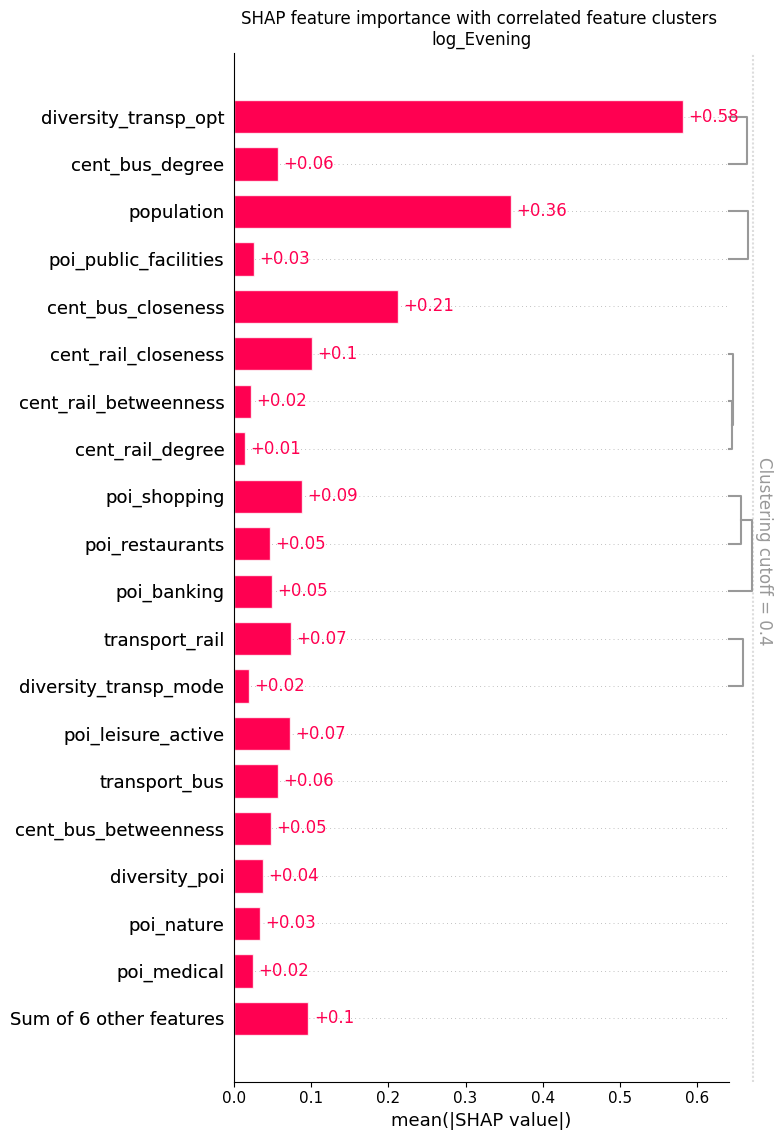

26it [00:48,  2.57s/it]                        


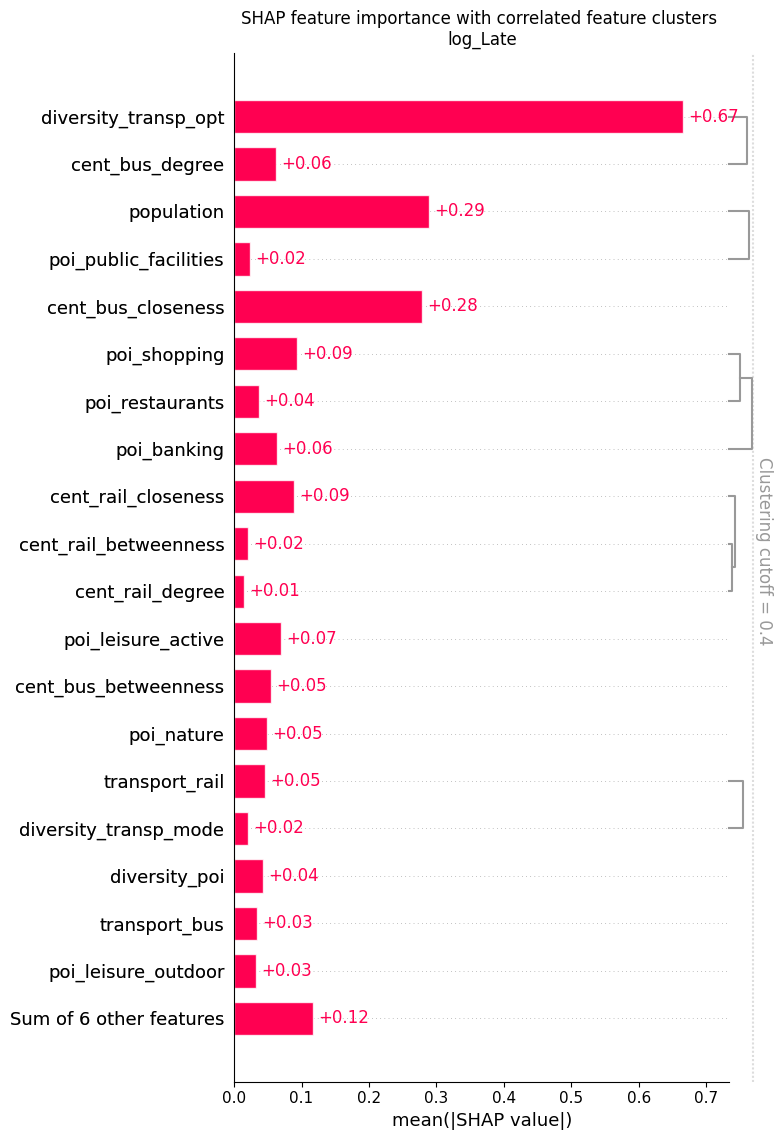

In [348]:
for target in targets_log:
    shap_values = shap_list_[target]
    
    target_sel = target
    features_sel = features

    X = df[features_sel]
    y = df[target_sel]

    clustering = shap.utils.hclust(X,y,metric='xgboost_distances_r2')
    shap.plots.bar(shap_values, max_display=20, clustering=clustering, clustering_cutoff=0.4,show=False)
    plt.title('SHAP feature importance with correlated feature clusters \n'+target)
    plt.tight_layout()
    # plt.savefig(f'output/shap/new_barclus_{target}.png')
    plt.show()

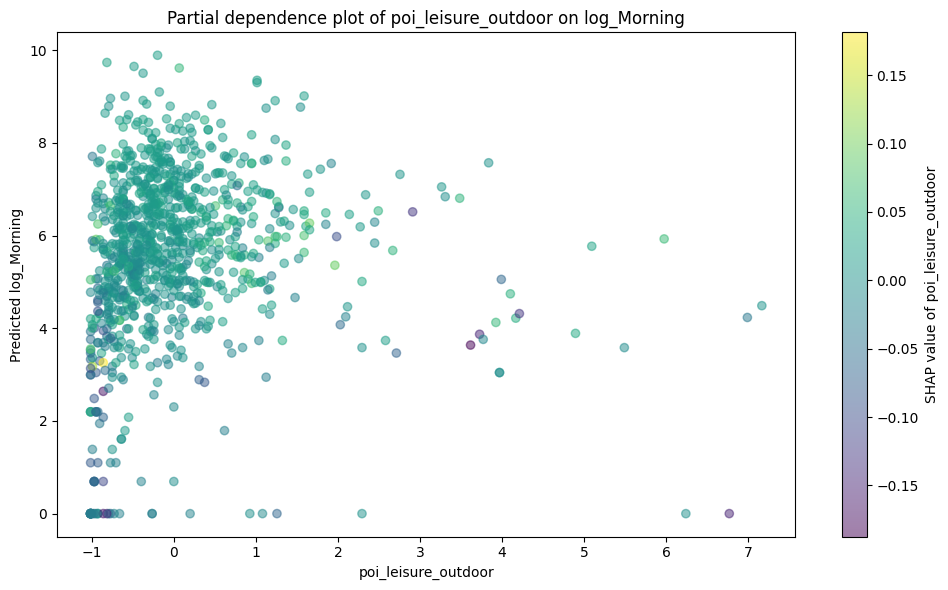

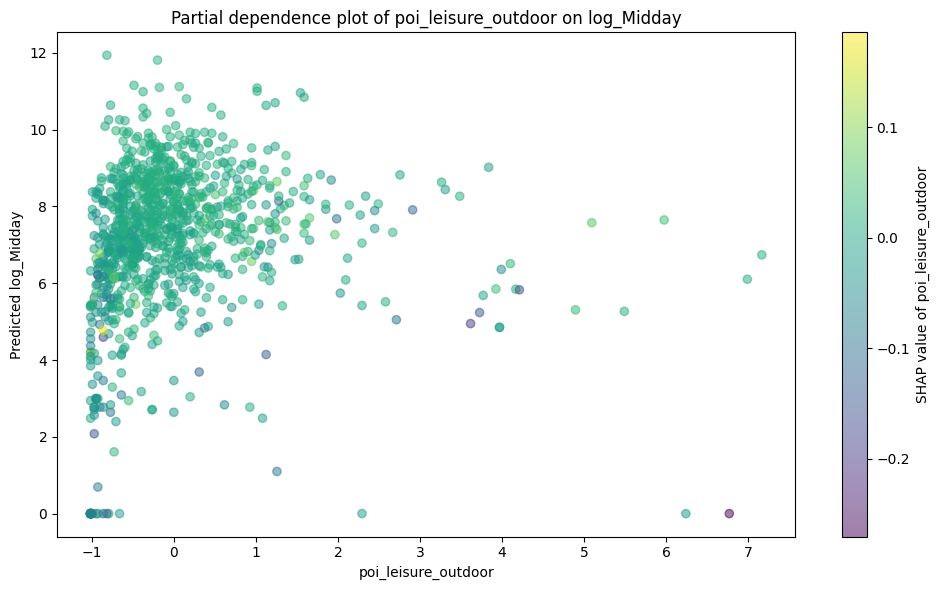

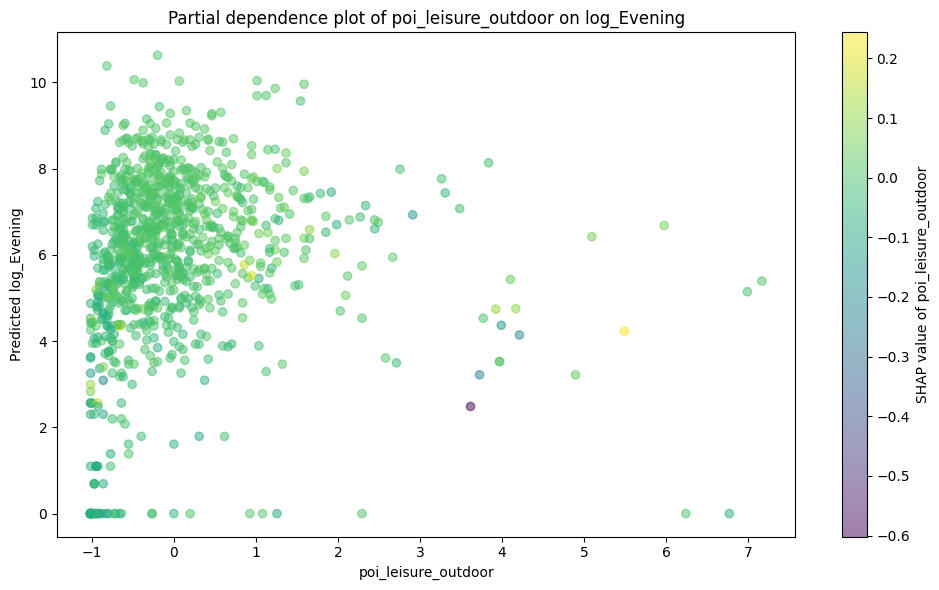

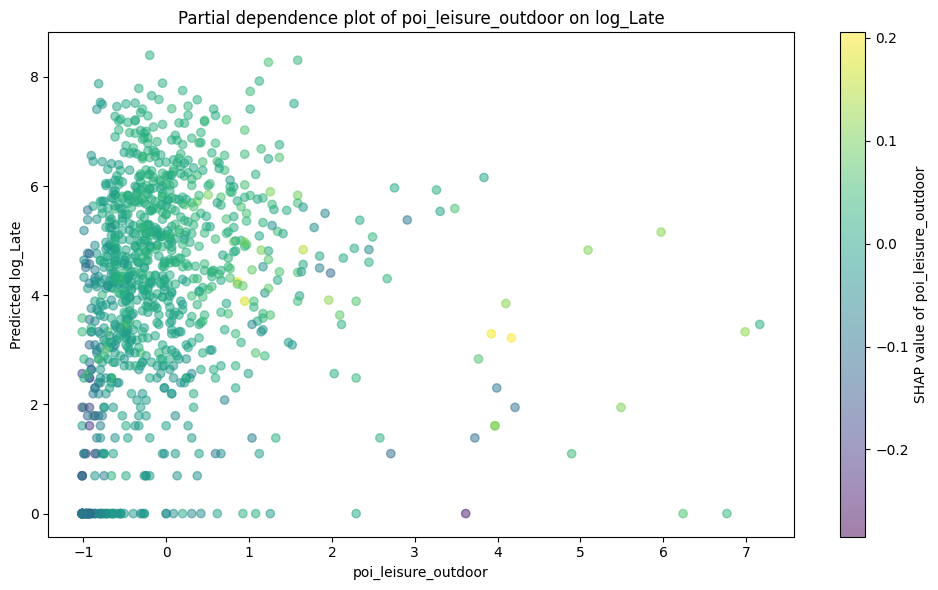

In [386]:
# partial depence plot for feature and prediction
def pd_plot(feature, target):
    X_ = df[features].sample(1000, random_state=random_seed,axis=0)
    y_ = df[target].sample(1000, random_state=random_seed,axis=0)

    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
    
    model.fit(X_, y_)
    y_pred = model.predict(X_)

    # plot X_ vs y_pred, color equals shap value of feature
    plt.figure(figsize=(10,6))
    plt.scatter(X_[:,features.index(feature)], y_pred, alpha=0.5, c=shap_list_[target].values[:,features.index(feature)])

    plt.xlabel(feature)
    plt.ylabel('Predicted '+target)

    cbar = plt.colorbar()
    cbar.set_label('SHAP value of '+feature)
    plt.title('Partial dependence plot of '+feature+' on '+target)
    plt.tight_layout()
    plt.show()

for target in targets_log[1:]:
    pd_plot('poi_leisure_outdoor',target)